In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

In [2]:
with pd.ExcelFile('results.xlsx') as xls:
    df_prices=pd.read_excel(xls,'prices')
    df_state=pd.read_excel(xls,'state')
    df_fuel=pd.read_excel(xls,'fuel')
    df_state_m=pd.read_excel(xls,'state monthwise')

with pd.ExcelFile('metadata_energy.xlsx') as xls:
    df_inflation=pd.read_excel(xls,'Sheet1')
    df_pop=pd.read_excel(xls,'Sheet2')
    
df_inflation


,year,adj
0,2001,0.813008
1,2002,0.829268
2,2003,0.845528
3,2004,0.869919
4,2005,0.894309
5,2006,0.926829
6,2007,0.951220
7,2008,0.991870
8,2009,0.983740
9,2010,1.000000


In [3]:
df_prices = df_prices.drop(['customers','revenue' ,'sales'],axis=1).loc[df_prices.price>0].loc[df_prices.sector!='other']
df_prices

,state,sector,price,date
0,WY,all sectors,4.31,2001-01-01
1,WY,commercial,5.13,2001-01-01
2,WY,industrial,3.26,2001-01-01
4,WY,residential,6.01,2001-01-01
6,SC,residential,7.36,2001-01-01
...,...,...,...,...
70375,IL,residential,14.98,2023-12-01
70376,IL,transportation,7.40,2023-12-01
70377,IN,all sectors,11.32,2023-12-01
70378,IN,commercial,12.57,2023-12-01


In [4]:
df_prices=df_prices[df_prices.sector!='transportation']
df_prices.head()

,state,sector,price,date
0,WY,all sectors,4.31,2001-01-01
1,WY,commercial,5.13,2001-01-01
2,WY,industrial,3.26,2001-01-01
4,WY,residential,6.01,2001-01-01
6,SC,residential,7.36,2001-01-01


In [5]:
d={i['year']:i['adj'] for i in df_inflation.to_dict('records')}

In [6]:
df_prices['price'] = df_prices.price / df_prices.date.dt.year.apply(lambda x : d[x])

C:\Users\aayus\AppData\Local\Temp\ipykernel_10844\773003782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prices['price'] = df_prices.price / df_prices.date.dt.year.apply(lambda x : d[x])


In [7]:
df_prices = df_prices.pivot(columns='sector',index=['state','date'],values='price').rename_axis(columns=None).reset_index()

In [8]:
#ifunc = { interp1d([2000,2010,2020])
df_pop1 = df_pop
df_pop1.head()

,Name,2000,2010,2020
0,AL,4447100,4779736,5024279
1,AK,626932,710231,733391
2,AS,57291,55519,49710
3,AZ,5130632,6392017,7151502
4,AR,2673400,2915918,3011524


In [9]:
ifunc={row.tolist()[0]:interp1d([2000,2010,2020],row.tolist()[1:], bounds_error=False, fill_value='extrapolate') for index,row in df_pop1.iterrows()}
def get_iter(row): # row is {'state':'XX', 'date':datetime_obj}
    return ifunc[row['state']](row['date'].year + row['date'].month/12)

In [10]:
ifunc['CA'](2015).sum()

38396089.5

In [11]:
df_state_m.head()

,state,date,fossil,geo,hydro,nuclear,secondary,solar,wind
0,AK,2001-01-01,485509.641,NaN,104549.118,NaN,NaN,NaN,86.518
1,AK,2001-02-01,455981.194,NaN,90110.610,NaN,NaN,NaN,74.121
2,AK,2001-03-01,487191.377,NaN,99843.153,NaN,NaN,NaN,80.502
3,AK,2001-04-01,404013.012,NaN,84614.771,NaN,NaN,NaN,70.577
4,AK,2001-05-01,399488.266,NaN,85130.287,NaN,NaN,NaN,69.214


In [12]:
df_state_m['population']=df_state_m[['date','state']].apply(get_iter,axis=1).astype(float)



In [13]:
df = pd.merge(df_state_m,df_prices,on=['state','date'])


In [14]:
df.describe()

,date,fossil,geo,hydro,nuclear,secondary,solar,wind,population,all sectors,commercial,industrial,residential
count,14076,1.407600e+04,1.572000e+03,1.324800e+04,8.364000e+03,13596.000000,6.828000e+03,9.564000e+03,1.407600e+04,14076.000000,14076.000000,14076.000000,14076.000000
mean,2012-06-16 01:44:20.869565184,4.442731e+06,2.242274e+05,4.660079e+05,2.173034e+06,117143.293848,1.175259e+05,3.943773e+05,6.151198e+06,9.567880,9.639909,7.097870,11.476023
min,2001-01-01 00:00:00,-1.094000e+03,-1.400000e+02,0.000000e+00,-2.967700e+04,-2107.450000,-3.000000e+00,0.000000e+00,5.013484e+05,4.470577,4.718942,1.103551,5.992308
25%,2006-09-23 12:00:00,1.458648e+06,9.747097e+03,4.610127e+04,8.888210e+05,11446.240500,1.571274e+03,1.567706e+04,1.744022e+06,7.402991,7.605880,5.201246,9.191102
50%,2012-06-16 00:00:00,3.170151e+06,2.148374e+04,1.232591e+05,1.568446e+06,67742.073000,1.105386e+04,9.031150e+04,4.336152e+06,8.408651,8.678333,6.039851,10.362439
75%,2018-03-08 18:00:00,6.063440e+06,2.256549e+05,3.210343e+05,2.929554e+06,172258.118603,6.359874e+04,3.871717e+05,7.114947e+06,10.595850,10.373094,7.518939,12.625289
max,2023-12-01 00:00:00,4.254309e+07,1.149988e+06,1.121010e+07,8.883354e+06,777237.983000,4.703238e+06,1.301731e+07,4.045193e+07,34.411615,35.206385,31.100077,37.997538
std,NaN,4.902648e+06,3.754253e+05,1.085493e+06,1.764843e+06,138916.732043,3.769673e+05,9.289747e+05,6.908045e+06,3.487255,3.352583,3.257734,3.733199


In [15]:
df.head()

,state,date,fossil,geo,hydro,nuclear,secondary,solar,wind,population,all sectors,commercial,industrial,residential
0,AK,2001-01-01,485509.641,NaN,104549.118,NaN,NaN,NaN,86.518,635956.058333,12.2631,11.9310,8.6715,13.8006
1,AK,2001-02-01,455981.194,NaN,90110.610,NaN,NaN,NaN,74.121,636650.216667,12.2016,12.1155,8.8929,14.0097
2,AK,2001-03-01,487191.377,NaN,99843.153,NaN,NaN,NaN,80.502,637344.375000,13.4193,12.8658,10.5534,15.0183
3,AK,2001-04-01,404013.012,NaN,84614.771,NaN,NaN,NaN,70.577,638038.533333,13.0257,12.5583,9.8154,14.7354
4,AK,2001-05-01,399488.266,NaN,85130.287,NaN,NaN,NaN,69.214,638732.691667,12.9765,12.5583,9.4095,14.9199


<Axes: >

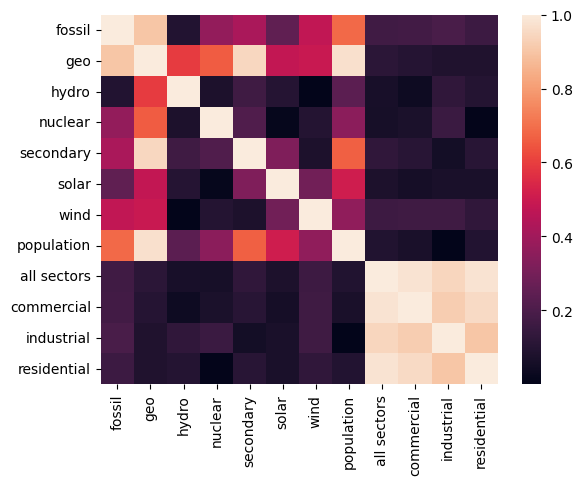

In [16]:
sns.heatmap(data=df.drop(['state','date'],axis=1).corr().abs())

In [17]:
df=df.fillna(0)

In [18]:
from sklearn.pipeline import Pipeline

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV

#Generate metrics for model
from sklearn.metrics import classification_report

import numpy as np

In [19]:
df['year']=df.date.dt.year
df['month']=df.date.dt.month

In [20]:
df=df.drop('date',axis=1)

In [21]:
df=pd.get_dummies(data=df)

In [22]:
df

,fossil,geo,hydro,nuclear,secondary,solar,wind,population,all sectors,commercial,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,485509.641,0.0,104549.118,0.0,0.000,0.0,86.518,635956.058333,12.263100,11.931000,...,False,False,False,False,False,False,False,False,False,False
1,455981.194,0.0,90110.610,0.0,0.000,0.0,74.121,636650.216667,12.201600,12.115500,...,False,False,False,False,False,False,False,False,False,False
2,487191.377,0.0,99843.153,0.0,0.000,0.0,80.502,637344.375000,13.419300,12.865800,...,False,False,False,False,False,False,False,False,False,False
3,404013.012,0.0,84614.771,0.0,0.000,0.0,70.577,638038.533333,13.025700,12.558300,...,False,False,False,False,False,False,False,False,False,False
4,399488.266,0.0,85130.287,0.0,0.000,0.0,69.214,638732.691667,12.976500,12.558300,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14071,3561549.633,0.0,52150.435,0.0,7502.356,19674.0,545853.540,581700.166667,6.285872,7.186919,...,False,False,False,False,False,False,False,False,False,True
14072,2907624.268,0.0,40594.580,0.0,7959.364,17129.0,544336.194,581810.375000,6.178605,7.258430,...,False,False,False,False,False,False,False,False,False,True
14073,3135331.086,0.0,39795.367,0.0,7741.733,13155.0,637403.721,581920.583333,6.071337,7.301337,...,False,False,False,False,False,False,False,False,False,True
14074,2811242.100,0.0,47015.170,0.0,8461.435,8312.0,966813.784,582030.791667,5.964070,7.215523,...,False,False,False,False,False,False,False,False,False,True


In [23]:
X=df.drop(['all sectors','commercial','industrial','residential','year','month'],axis=1)
y=df[['all sectors','commercial','industrial','residential']]
X.columns

Index(['fossil', 'geo', 'hydro', 'nuclear', 'secondary', 'solar', 'wind',
       'population', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV',
       'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA',
       'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='object')

In [24]:
pipeline = Pipeline([
    ('clf',MultiOutputRegressor(LinearRegression()))
], verbose=True)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
pipeline.get_params()

{'memory': None,
 'steps': [('clf', MultiOutputRegressor(estimator=LinearRegression()))],
 'verbose': True,
 'clf': MultiOutputRegressor(estimator=LinearRegression()),
 'clf__estimator__copy_X': True,
 'clf__estimator__fit_intercept': True,
 'clf__estimator__n_jobs': None,
 'clf__estimator__positive': False,
 'clf__estimator': LinearRegression(),
 'clf__n_jobs': None}

In [27]:
pipeline.fit(X_train,y_train).score(X_test, y_test)


[Pipeline] ............... (step 1 of 1) Processing clf, total=   1.3s


0.8732406469123556

In [28]:
y_pred=pipeline.predict(X_test)

In [29]:
y_pred[0]

array([7.77991543, 7.39741261, 5.70040012, 8.93077071])

In [30]:
y_test.iloc[0]


all sectors    6.031316
commercial     5.793947
industrial     4.456053
residential    6.991579
Name: 3359, dtype: float64

In [31]:
((y_pred-y_test)**2).mean(axis=0)**0.5


all sectors    1.176731
commercial     1.194844
industrial     1.292132
residential    1.360168
dtype: float64

In [32]:
from sklearn import metrics
metrics.mean_squared_error(y_test,y_pred)**0.5


1.2581745851068422

In [33]:
df_err=(y_test - y_pred).abs()/(y_test)

df_err.melt()

,variable,value
0,all sectors,0.289920
1,all sectors,0.039396
2,all sectors,0.067348
3,all sectors,0.020348
4,all sectors,0.146956
...,...,...
14071,residential,0.066619
14072,residential,0.064705
14073,residential,0.005295
14074,residential,0.070650


In [34]:
df_err=df_err.melt()
df_err

,variable,value
0,all sectors,0.289920
1,all sectors,0.039396
2,all sectors,0.067348
3,all sectors,0.020348
4,all sectors,0.146956
...,...,...
14071,residential,0.066619
14072,residential,0.064705
14073,residential,0.005295
14074,residential,0.070650


In [35]:
import math
df_err['value']=df_err.value.apply(lambda x : 2+math.log10(x))

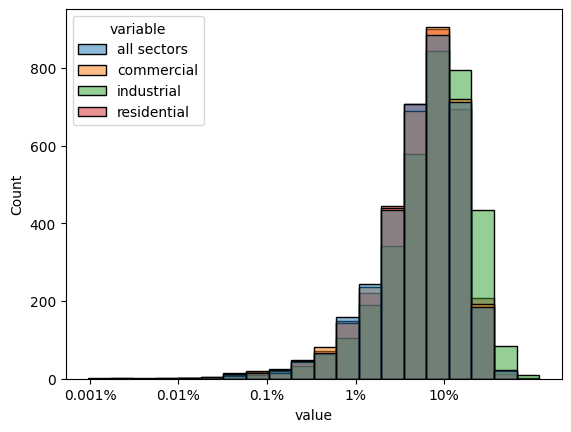

In [36]:
ax = sns.histplot(data=df_err,hue='variable',x='value',bins=20)
ax.set_xticks([-3,-2,-1,0,1])
ax.set_xticklabels(['0.001%', '0.01%', '0.1%','1%','10%']);

In [37]:
metrics.r2_score(y_test,y_pred)

0.8732406469123556

In [38]:
df

,fossil,geo,hydro,nuclear,secondary,solar,wind,population,all sectors,commercial,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,485509.641,0.0,104549.118,0.0,0.000,0.0,86.518,635956.058333,12.263100,11.931000,...,False,False,False,False,False,False,False,False,False,False
1,455981.194,0.0,90110.610,0.0,0.000,0.0,74.121,636650.216667,12.201600,12.115500,...,False,False,False,False,False,False,False,False,False,False
2,487191.377,0.0,99843.153,0.0,0.000,0.0,80.502,637344.375000,13.419300,12.865800,...,False,False,False,False,False,False,False,False,False,False
3,404013.012,0.0,84614.771,0.0,0.000,0.0,70.577,638038.533333,13.025700,12.558300,...,False,False,False,False,False,False,False,False,False,False
4,399488.266,0.0,85130.287,0.0,0.000,0.0,69.214,638732.691667,12.976500,12.558300,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14071,3561549.633,0.0,52150.435,0.0,7502.356,19674.0,545853.540,581700.166667,6.285872,7.186919,...,False,False,False,False,False,False,False,False,False,True
14072,2907624.268,0.0,40594.580,0.0,7959.364,17129.0,544336.194,581810.375000,6.178605,7.258430,...,False,False,False,False,False,False,False,False,False,True
14073,3135331.086,0.0,39795.367,0.0,7741.733,13155.0,637403.721,581920.583333,6.071337,7.301337,...,False,False,False,False,False,False,False,False,False,True
14074,2811242.100,0.0,47015.170,0.0,8461.435,8312.0,966813.784,582030.791667,5.964070,7.215523,...,False,False,False,False,False,False,False,False,False,True


In [39]:
def prediction_bckup(energy_util,population,state):
    """
    Predict cost of energy for given data.
    Input : 
        - energy_util : tuple of energy generated in megawatt-hours for (fossil, geo, hydro, nuclear, secondary, solar, wind)
        - state
    Output :
        - pred : prediction tuple for ( all sectors, commercial, industrial, residential)
    """
    vec=[i for i in energy_util]+[population,state]
    vec = vec[:8] + [vec[-1] in i for i in X.columns[8:]]
    pred= (pipeline.predict(
            pd.DataFrame(
                    data= vec,
                    index = X.columns).T)  ).round(2)
    
    df1 = df_state_m.loc[df_state_m.state==state]
    df1 = df1.iloc[(df1['population']-population).abs().argsort()[:10]].fillna(0)
    energy_util_cat=['fossil','geo','hydro','nuclear','secondary','solar','wind'] # order of categories
    for en,i in enumerate(energy_util_cat):
        if energy_util[en]==0:
            df1=df1[df1[i]==0]
        else : df1 = df1.iloc[(df1[i]-energy_util[en]).abs().argsort()[: df1.shape[0]-1 ]]
        if df1.shape[0]<=1 : break
    print("Closest dates match = \n",df1.date)
    print()
    actual = df_prices.loc[df_prices.state==state].loc[df_prices.date.isin(df1.date.tolist())]
    
    print("Actual generation for these dats is/are :\n",actual)
    #print("Actual prices for data are:\n",actual)
    print()
    print("Predicted prices are:\n",pd.DataFrame( pred,columns=['all sectors','commercial','industrial','residential']) )
    

    


In [233]:
def prediction(energy_util,population,state, n_closest = 5):
    """
    Predict cost of energy for given data.
    Input : 
        - energy_util : tuple of energy generated in megawatt-hours for (fossil, geo, hydro, nuclear, secondary, solar, wind)
        - state
    Output :
        - pred : prediction tuple for ( all sectors, commercial, industrial, residential)
    """
    vec_input=[i for i in energy_util]+[population,state]
    vec= vec_input # [i for i in energy_util]+[population,state]
    vec = vec[:8] + [vec[-1] in i for i in X.columns[8:]]
    pred= (pipeline.predict(
            pd.DataFrame(
                    data= vec,
                    index = X.columns).T)  ).round(2)
    
    df1 = df_state_m.loc[df_state_m.state==state]
    df1 = df1.iloc[(df1['population']-population).abs().argsort()[:10]].fillna(0)
    
    df2 = df1.drop(['state','date'],axis=1).fillna(0)
    if 'month' in df2.columns:
        df2.drop('month',axis=1,inplace=True)
    a = pd.DataFrame(vec_input[:-1],index=df2.columns).T # convert input into a DF with single row so we can calcullate correlation
    a = ((a-df2.mean())/df2.std()).fillna(0) #standardize a
    df2 = ((df2 - df2.mean())/ (df2.std())).fillna(0) #standardixe df2
    corr_idx = df2.corrwith( a.iloc[0] , axis=1 ).sort_values(ascending=False).index.tolist() # these are the closes matches
    corr_idx = corr_idx[:n_closest] # select top n_closest matches
    
    df1 = df1.loc[corr_idx]
    
    print("Closest dates match = \n",df1.date)
    print()
    actual =  df_prices.loc[df_prices.state==state].loc[df_prices.date.isin(df1.date)] 
    
    print("Actual generation for these dats is/are :\n",actual)
    #print("Actual prices for data are:\n",actual)
    print()
    print("Predicted prices are:\n",pd.DataFrame( pred,columns=['all sectors','commercial','industrial','residential']) )
    

    


In [235]:
#prediction((67695310,0,64187,1528077,218557,26532,0),4691962,'LA')

prediction((67695310,0,64187,1528077,218557,26532,0),4691962,'LA')
#energy_util= (6769530,0,64187,1528077,218557,26532,0)
#population = 4691962
#state='LA'

#vec_input=[i for i in energy_util]+[population,state]

#vec = vec_input[:8] + [vec_input[-1] in i for i in X.columns[8:]]
#pred= (pipeline.predict(
#            pd.DataFrame(
#                    data= vec,
#                    index = X.columns).T)  ).round(2)

#df1 = df_state_m.loc[df_state_m.state==state]
#df2 = df1.drop(['state','month','date'],axis=1).fillna(0)
#print(vec_input)
#a = pd.DataFrame(vec_input[:-1],index=df2.columns).T
#corr_idx = ((df2 - df2.mean())/ (df2.std())).fillna(0).corrwith( ((a-df2.mean())/df2.std()).fillna(0).iloc[0] , axis=1 ).sort_values(ascending=False).index.tolist()[:5]
#df1.loc[corr_idx].date
#df_prices.loc[df_prices.state==state].loc[df_prices.date.isin(df1.loc[corr_idx].date)]


Closest dates match = 
 13074   2022-07-01
13075   2022-08-01
13073   2022-06-01
13072   2022-05-01
13071   2022-04-01
Name: date, dtype: datetime64[ns]

Actual generation for these dats is/are :
      state       date  all sectors  commercial  industrial  residential
5223    LA 2022-04-01     6.828364    8.162727    4.860364     9.131818
5224    LA 2022-05-01     6.970000    8.088182    4.860364     9.109455
5225    LA 2022-06-01     7.849636    8.684545    5.672909     9.720727
5226    LA 2022-07-01     8.885818    9.541818    6.724000    10.503455
5227    LA 2022-08-01     8.751636    9.519455    6.604727    10.540727

Predicted prices are:
    all sectors  commercial  industrial  residential
0         9.28         8.9        9.33         4.32


In [237]:
y_pred_all=pipeline.predict(X)

In [238]:
y_pred_all = pd.DataFrame(data=y_pred_all,columns=y.columns)

In [239]:
y_scat = pd.merge(y.melt(),y_pred_all.melt(),left_index=True,right_index=True).drop('variable_x',axis=1)

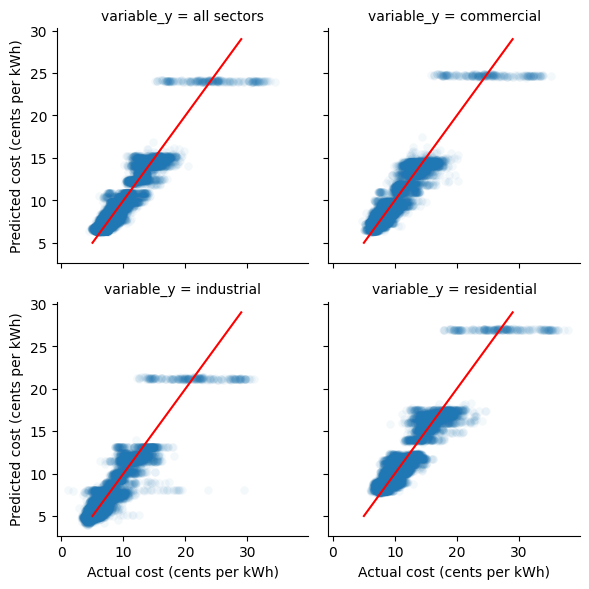

In [240]:

#sns.scatterplot(data=y_scat,x='value_x',y='value_y',hue='variable_y')

graph = sns.FacetGrid(y_scat, col ="variable_y", col_wrap=2)
graph.map(sns.scatterplot, "value_x", "value_y" ,alpha=0.05, linewidth=0)

def const_line(*args, **kwargs):
    x = np.arange(5, 30, 1)
    y = x
    plt.plot(y, x, c='r')

graph.map(const_line)
graph.set_xlabels('Actual cost (cents per kWh)')
graph.set_ylabels('Predicted cost (cents per kWh)')
    

In [241]:
pipeline['clf'].estimators_[2].coef_

array([ 6.09006541e-08, -8.64915431e-06, -3.34633996e-08,  1.43884587e-07,
        2.89383705e-06,  5.26755777e-07, -4.06409559e-08, -3.14600747e-07,
       -3.45954511e+04, -3.46035770e+04, -3.46031853e+04, -3.46015406e+04,
       -3.45798537e+04, -3.46009513e+04, -3.45967720e+04, -3.46005318e+04,
       -3.46010925e+04, -3.45985112e+04, -3.46019753e+04, -3.45871602e+04,
       -3.46027816e+04, -3.46033589e+04, -3.46004999e+04, -3.46015823e+04,
       -3.46019377e+04, -3.46031484e+04, -3.46029150e+04, -3.45950802e+04,
       -3.45996906e+04, -3.46004920e+04, -3.46005183e+04, -3.46016617e+04,
       -3.46017732e+04, -3.46028215e+04, -3.46033687e+04, -3.46016380e+04,
       -3.46027308e+04, -3.46025244e+04, -3.45970224e+04, -3.45968105e+04,
       -3.46026912e+04, -3.45995253e+04, -3.45970260e+04, -3.46001451e+04,
       -3.46028142e+04, -3.46023888e+04, -3.46004982e+04, -3.45963537e+04,
       -3.46033012e+04, -3.46024191e+04, -3.46019663e+04, -3.45972307e+04,
       -3.46028741e+04, -

In [46]:
y_scat['diff']=((y_scat.value_x - y_scat.value_y)/y_scat.value_x).abs().apply(lambda x: math.log10(x))

Text(0.5, 1.0, 'Histogram of error in estimation of energy prices for different sectors')

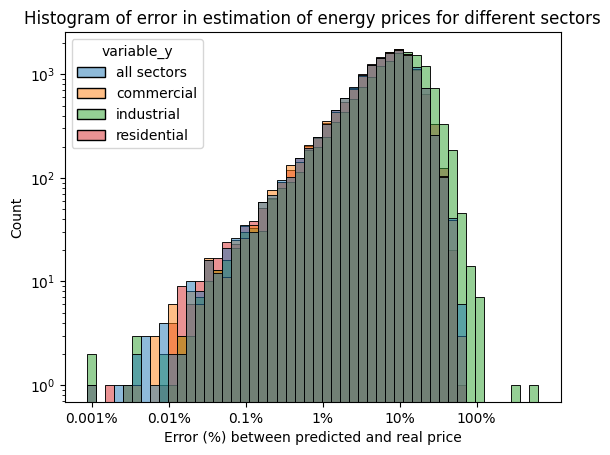

In [47]:
g = sns.histplot(data=y_scat, x='diff',hue='variable_y',bins=50)
g.set_yscale('log')
g.set_xticks([-5, -4,-3,-2,-1,0])
g.set_xticklabels(['0.001%', '0.01%', '0.1%', '1%', '10%', '100%' ]);
g.set_xlabel('Error (%) between predicted and real price')
g.set_title('Histogram of error in estimation of energy prices for different sectors')

<Axes: xlabel='date', ylabel='solar'>

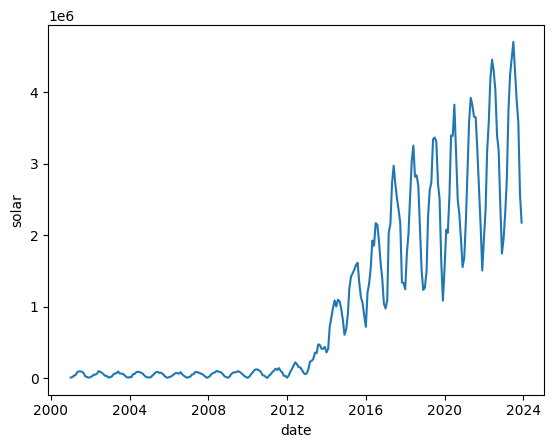

In [48]:
sns.lineplot(data=df_state_m.loc[df_state_m.state=='CA'],x='date',y='solar')
#sns.lineplot(data=df_state_m.groupby('state').sum(),x='date',y='solar')


Text(0, 0.5, 'MWh generation of each category')

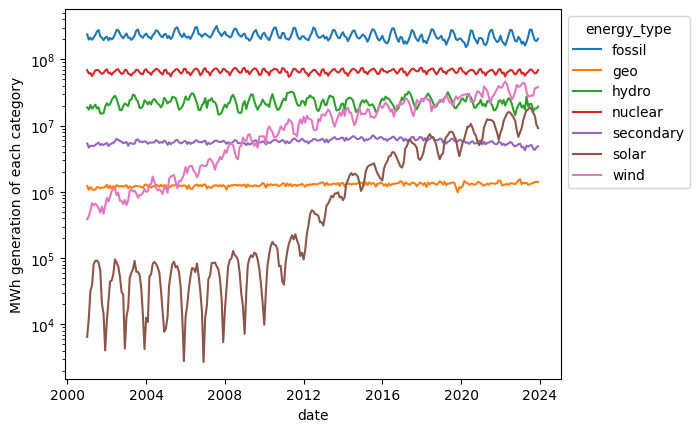

In [49]:
#sns.lineplot(data=df_state_m.drop('state',axis=1).groupby('date',as_index=False).sum(),x='date')
#df_state_m.columns
ax = sns.lineplot(data=df_state_m.drop(['state','population'],axis=1).groupby('date',as_index=False).sum().melt(id_vars='date', var_name='energy_type'),x='date',hue='energy_type',y='value')
sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
ax.set_yscale('log')
ax.set_ylabel('MWh generation of each category')

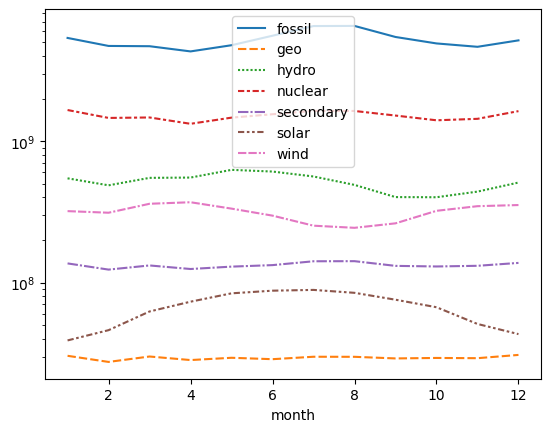

In [62]:
df_state_m['month'] = df_state_m.date.dt.month
sns.lineplot(data=df_state_m.drop(['date','population'],axis=1).groupby('month').sum())
plt.yscale('log')